# Data Analysis and customer segmentation of a French retailer

### Exploratory Data Analysis


First, i will dive into the exploration of each dataset, and then i'll try to find links between thoses files.   
#### Clients  
Let's try to better understand the Dataset:   

In [938]:
import pandas as pd
import numpy as np
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as snd
from sklearn.cluster import KMeans
from sklearn.preprocessing import OrdinalEncoder
kmeans_model = KMeans(init='k-means++', 
                      max_iter=500, 
                      random_state=42)


In [967]:
#Customers main informations
customers= pd.read_csv("clients.csv")
print(customers.describe())
print(customers.head())
print(customers.isnull().sum())

          client_id           age        zipcode
count  1.344860e+05  15025.000000  134289.000000
mean   2.346871e+06     53.496306   49341.873601
std    1.715192e+06     17.054609   26775.359646
min    0.000000e+00      1.000000       0.000000
25%    7.966940e+05     44.000000   27550.000000
50%    1.998013e+06     56.000000   51420.000000
75%    3.958976e+06     66.000000   71600.000000
max    5.314189e+06    121.000000   99000.000000
   client_id client_date  age client_type  zipcode country
0        0.0  2014-06-05  NaN    Monsieur  80310.0      FR
1        9.0  2014-07-29  NaN    Monsieur  59148.0      FR
2       17.0  2014-06-23  NaN    Monsieur  60200.0      FR
3       20.0  2014-06-14  NaN    Monsieur   2120.0      FR
4       23.0  2014-07-18  NaN    Monsieur  59139.0      FR
client_id           0
client_date         0
age            119461
client_type         0
zipcode           197
country             0
dtype: int64


The dataset is composed of 6 columns and about 150 000 rows. First thing that comes to my mind is that several ages are missing, and therefore it is feasible to study them, but it will be complicated to fit the maching learning model with this column since there are only 10 percent of data.  
However, only 197 zipcodes are missing, and we will do some imputation to fill the missing values.  
Let's dive into the study of each columns, starting with the age : 

          client_id           age       zipcode
count  1.502500e+04  15025.000000  15025.000000
mean   1.985206e+06     53.496306  49205.104759
std    1.561057e+06     17.054609  25554.537601
min    2.356000e+03      1.000000   1000.000000
25%    6.464740e+05     44.000000  28110.000000
50%    1.512294e+06     56.000000  51350.000000
75%    3.210899e+06     66.000000  69971.000000
max    5.314171e+06    121.000000  95940.000000


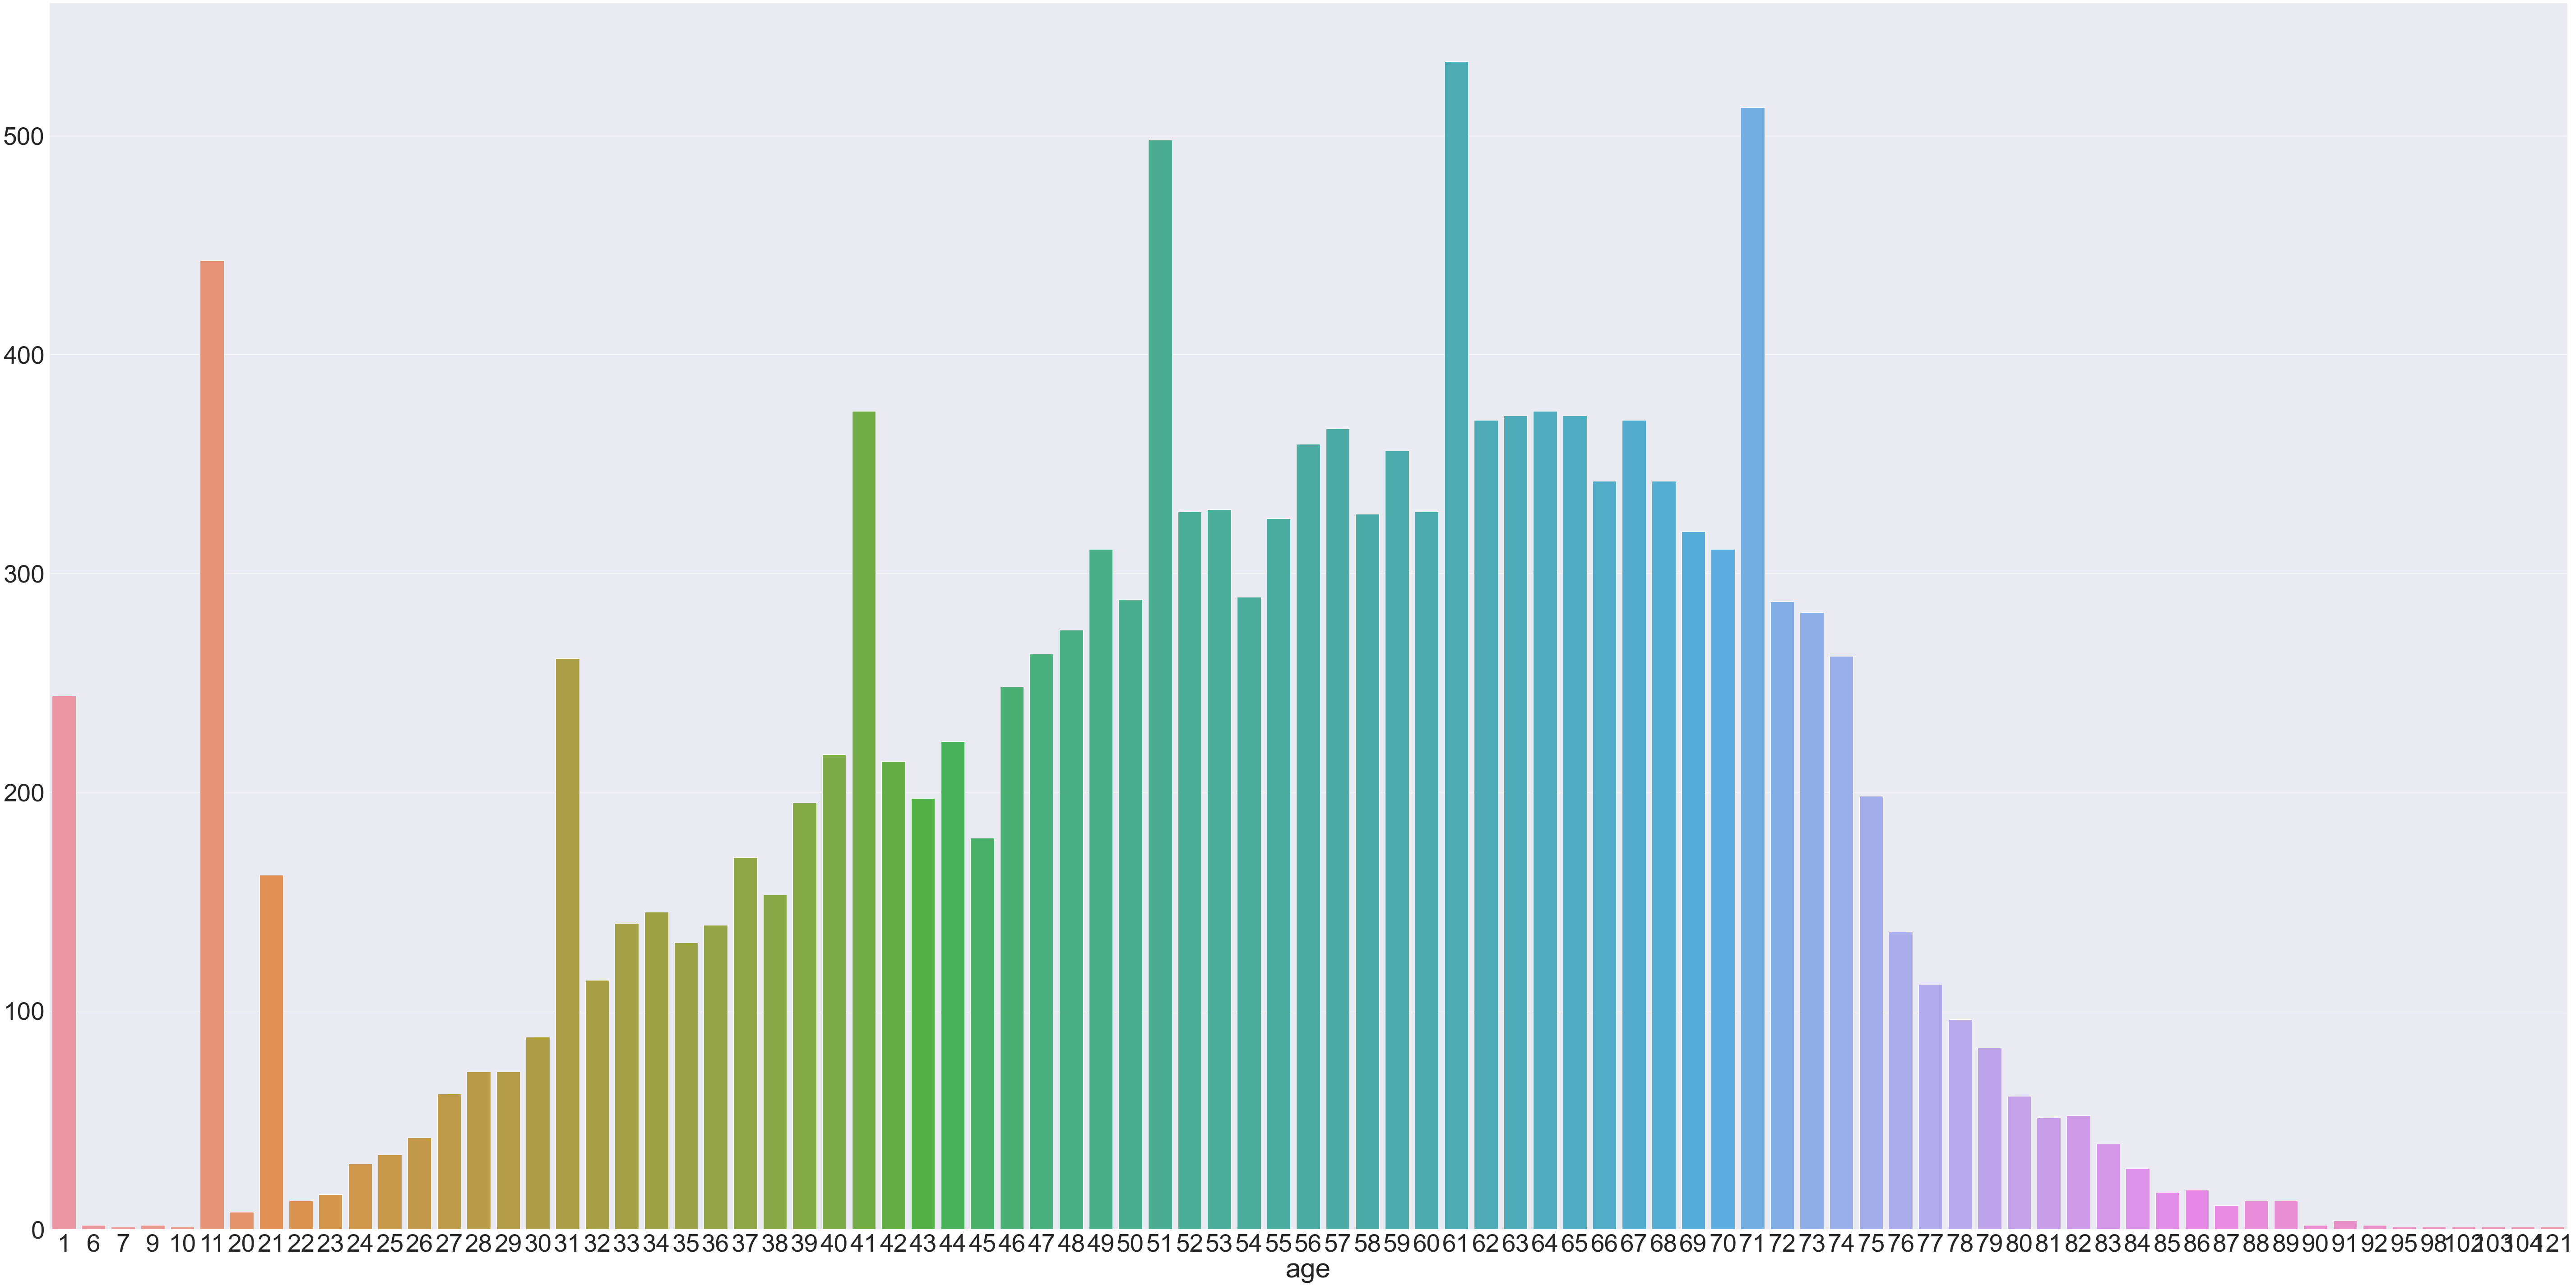

In [940]:
age_customers = customers[~customers.age.isnull()].copy()
age_customers.age = age_customers.age.astype("int64")
plt.figure(figsize = ( 100,50))
sns.set(font_scale = 5)
#Printing datas
print(age_customers.describe())
bp_age_customers = sns.barplot(x = age_customers.groupby("age").size().keys(), y = age_customers.groupby("age").size())
plt.show()

The average age is 53, and as we can see on the bar chart, most people are more than 40 and less than 75 old. We can see there are some outliers, for instance there are more than 200 people that are 1 year old and 400 people are 11 years old, which seems curious : we will delete those values. Since they are several values missing it will be tough to take into account this feature.  
Let's look at the client type : 

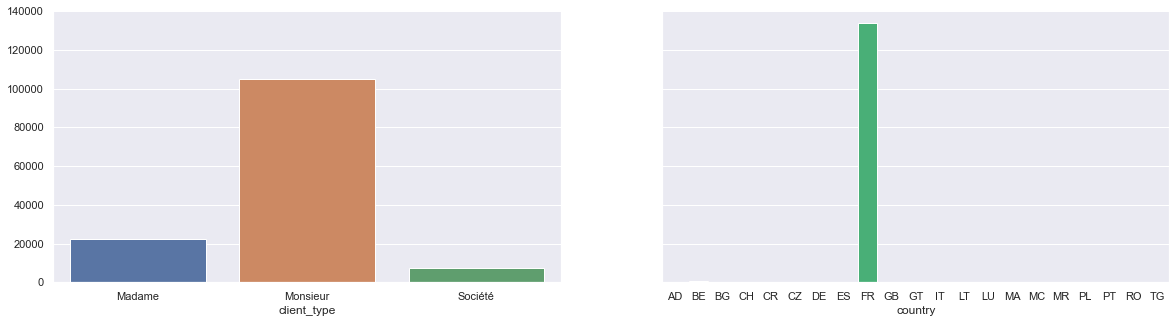

In [942]:
fig, axes = plt.subplots(1, 2, figsize=(20, 5), sharey=True)
sns.set(font_scale = 1)
bp1 =sns.barplot(ax = axes[0],x = customers.groupby("client_type").size().keys(), y = customers.groupby("client_type").size())
bp2 = sns.barplot(ax = axes[1], x = customers.groupby("country").size().keys(), y = customers.groupby("country").size())

plt.show()


As we can see on the bar charts, the company is mostly visited by french men which are more than 40 years old. THe country seems not to be a good feature since almost every customer comes from France.

#### Products

In [943]:
#Products main informations 
products = pd.read_csv("products.csv")
print(products.describe())
print(products.head())
print(products.isnull().sum())



          product_id
count   34861.000000
mean   428341.395514
std    273639.150364
min         0.000000
25%    171742.000000
50%    438264.000000
75%    681767.000000
max    911189.000000
   product_id                product_cat
0      291680                   Dressing
1      283879  Matériaux de construction
2      283878  Matériaux de construction
3      283877  Matériaux de construction
4      283876  Matériaux de construction
product_id     0
product_cat    0
dtype: int64


The dataset is composed of 34861 rows, 2 colums, there are no missing values, which will help to fit an efficient model.

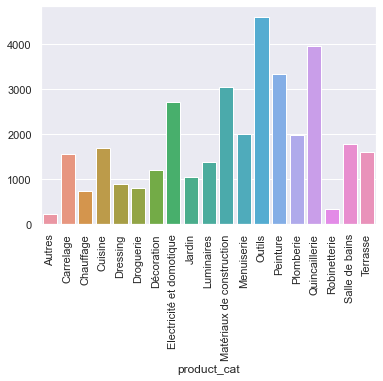

In [944]:
barplot_products_category = sns.barplot(x = products.groupby("product_cat").size().keys(), y = products.groupby("product_cat").size())
sns.set(font_scale = 1)
barplot_products_category.set_xticklabels(labels = products.groupby("product_cat").size().keys(), rotation = 90)
plt.show()

Data finally reveal that we are in front of an home improvement and gardening retailer, and therefore its main customer base is composed by french men aged between 30 and 60 years old. Since the products seems to be well distributed, it will be an efficient feature for the model.

#### Transactions  
The main subject of interest in the data provided is the transactions : it gives information about what customers has bought, when, and in which store. In this part, we will try to merge the data from the 3 CSV files to create a customer segmentation.  

In [945]:
transactions = pd.read_csv("transactions_light.csv")
print(transactions.describe())
print(transactions.head())
print(transactions.isnull().sum())

          ticket_id    product_id      store_id     client_id          hour  \
count  1.684992e+07  1.684992e+07  1.684992e+07  1.684992e+07  1.684992e+07   
mean   2.951271e+06  4.595856e+05  1.022263e+02  1.774006e+06  1.268735e+01   
std    1.695940e+06  2.764018e+05  8.174476e+01  1.525090e+06  3.438908e+00   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  5.000000e+00   
25%    1.496308e+06  1.936180e+05  4.400000e+01  4.108130e+05  1.000000e+01   
50%    2.949738e+06  4.249310e+05  7.200000e+01  1.388751e+06  1.200000e+01   
75%    4.415670e+06  7.271510e+05  2.050000e+02  2.878697e+06  1.600000e+01   
max    5.882807e+06  9.111890e+05  2.550000e+02  5.314189e+06  2.200000e+01   

         n_products    price_ttc  
count  1.684992e+07  16849407.00  
mean   2.377539e+00          inf  
std    7.185690e+00          NaN  
min    0.000000e+00         0.00  
25%    1.000000e+00         4.54  
50%    1.000000e+00         9.72  
75%    2.000000e+00        23.25  
max    4

There are more than 10 millions of transactions to take into account, which will help our model to converge more easily. The Dataset is well filled since there are only 509 price missing. We delete those rows were there are not a price, since they only represent 0.005 % of the data.   
We have also noticed that 50 rows have an infinite price_ttc value, we will also delete thoses values sinces they seems to be outliers.

In [946]:
transactions.dropna(inplace = True)
transactions.drop(transactions[transactions.price_ttc >100000].index,inplace = True)

Let's first try to better understand where the turnover of each store : doing this, we will evaluate if it is a good idea to take into account where a customer has bought something :

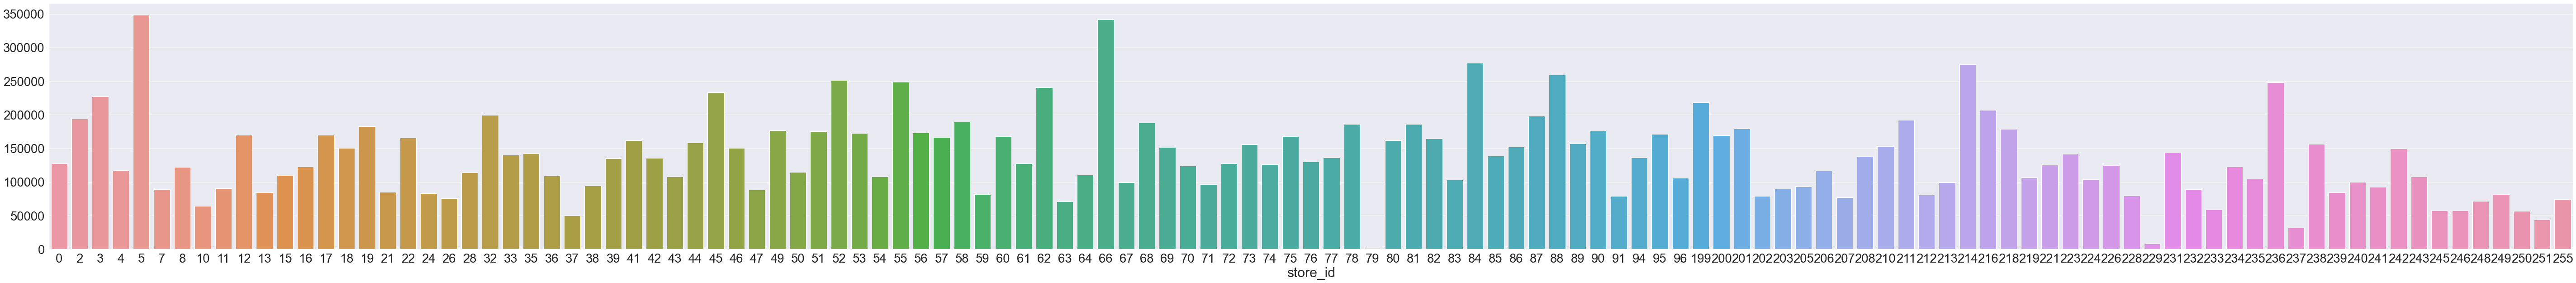

count       123.000000
mean     136986.642276
std       60517.058863
min        1857.000000
25%       92869.500000
50%      127472.000000
75%      169876.500000
max      348664.000000
dtype: float64


In [947]:
stores = transactions.groupby("store_id").size()
plt.figure(figsize = (100,10))
sns.set(font_scale = 2.5)
bp_stores = sns.barplot(x = stores.keys(), y = stores)
plt.show()
print(stores.describe())

Each stores has made about 100 000 transactions and we cannot see huge differences between stores, it is unfeasible to identifiate groups among the stores.  
We will now try to delve into customers profiles : 

In [948]:
nbVisites = transactions.groupby(["client_id","date"]).size().groupby("client_id").size()
price_customers_mean = transactions.groupby(["client_id","date"]).price_ttc.sum().groupby("client_id").mean()
price_customers_sum = transactions.groupby("client_id").price_ttc.sum()
print("nbVisitesPerCustomers",nbVisites.describe(),sep = '\n')
print("Average price transaction")
print(price_customers_mean.describe())
print("Total sum of transaction per client")
print(price_customers_sum.describe())


nbVisitesPerCustomers
count    134479.000000
mean         31.813413
std          36.446694
min           1.000000
25%           9.000000
50%          21.000000
75%          41.000000
max         662.000000
dtype: float64
Average price transaction
count    134479.000000
mean        112.727526
std         119.958208
min           0.200000
25%          48.375692
50%          79.138462
75%         133.902104
max        5770.865000
Name: price_ttc, dtype: float64
Total sum of transaction per client
count    134479.000000
mean       3135.433456
std        5604.857578
min           0.200000
25%         701.295000
50%        1673.430000
75%        3600.160000
max      566558.320000
Name: price_ttc, dtype: float64


As we can see, there are huge differences between customers regading their average amount of money spent during one visit ( the standard deviation is 119€) : it will be indeed a good feature to caracterize customers. The numbers of visits made by clients seems to be an efficient feature as well.  Moreover, we do not need to make a logarithmic transformation of the data since they seems to be well distributed. 
We will now to determine carateristics regarding the price of each transactions : in order to do that, we will create slices which have each a length of 5 €.

In [954]:
transactionsBis = transactions.copy()
transactionsBis = pd.cut(transactions.groupby(["client_id","date"]).price_ttc.sum(),[5*i for i in range(50)])
print(transactionsBis)

client_id  date      
0.0        2018-01-06      (25.0, 30.0]
           2018-03-03    (185.0, 190.0]
           2018-03-10      (25.0, 30.0]
           2018-05-03      (35.0, 40.0]
           2018-05-09      (15.0, 20.0]
                              ...      
5314188.0  2020-08-27               NaN
           2020-08-31      (55.0, 60.0]
           2020-09-02      (65.0, 70.0]
           2020-10-12    (140.0, 145.0]
5314189.0  2020-08-27      (30.0, 35.0]
Name: price_ttc, Length: 4278236, dtype: category
Categories (49, interval[int64, right]): [(0, 5] < (5, 10] < (10, 15] < (15, 20] ... (225, 230] < (230, 235] < (235, 240] < (240, 245]]


[]

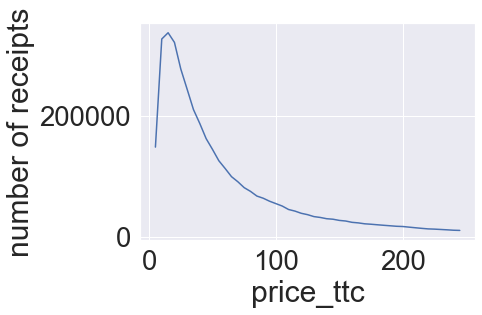

In [955]:

transactionsBis = transactionsBis.reset_index()

transactionsBis.price_ttc= transactionsBis.price_ttc.map(lambda a : a.right)
sns.lineplot(x = transactionsBis.groupby("price_ttc").size().keys(), y = transactionsBis.groupby("price_ttc").size())
plt.ylabel("number of receipts")
plt.plot()

The overwhelming majority of transactions costs less than 20 euros : in order to make that criteria relevant, we will to make a logarithmic transformation of those data. 

The next step in the EDA is to merge the informations coming from the 3 CSV files : we will first merge prodcuts and transactions : 

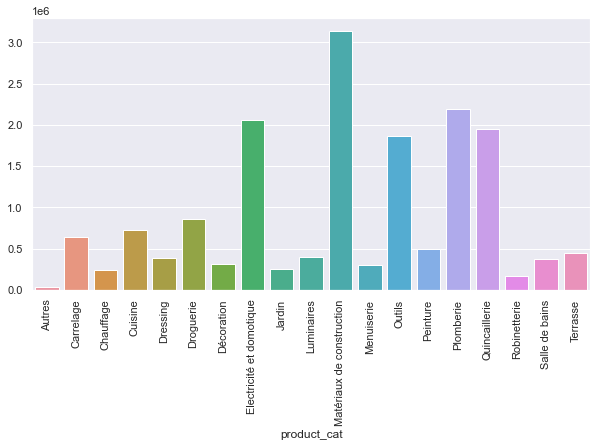

In [956]:
prd = products.set_index(["product_id"])
trs = transactions.set_index(["product_id"])
products_transactions = prd.join(trs,lsuffix ="pr",rsuffix = "tr") 
#Some products have never been bought, we have to delete those rows.
products_transactions.dropna(inplace = True)


#Printing the figure : 
plt.figure(figsize = (10,5))
sns.set(font_scale = 1)
bp_product_transactions = sns.barplot(x =products_transactions.groupby("product_cat").size().keys(), y = products_transactions.groupby("product_cat").size())
bp_product_transactions.set_xticklabels(labels = products.groupby("product_cat").size().keys(), rotation = 90)
plt.show()

Over all, there are huge differences between product categories regarding the amount of transactions. Let's try to see if can create customer profiles based on this reflexion : 


In [957]:
products_transactions.reset_index(inplace = True)
products_transactions.set_index(["client_id"],inplace= True)
customers.reset_index(inplace = True)
customers.set_index(["client_id"],inplace= True)
customers_products_transactions = products_transactions.join(customers, lsuffix = "lp", rsuffix = "")
print(customers_products_transactions)

           product_id                product_cat  ticket_id  store_id  \
client_id                                                               
0.0                 8                     Autres  5848816.0      62.0   
0.0             12201              Quincaillerie  2496031.0      62.0   
0.0             12321              Quincaillerie  2427808.0      62.0   
0.0             12322              Quincaillerie  2427808.0      62.0   
0.0             12345              Quincaillerie  2453753.0      62.0   
...               ...                        ...        ...       ...   
5314188.0      614529                   Peinture  1275820.0      39.0   
5314188.0      642660  Matériaux de construction  1322608.0      39.0   
5314188.0      726384               Robinetterie  1275820.0      39.0   
5314188.0      743046   Electricité et domotique  1275820.0      39.0   
5314189.0      144023                     Outils   223173.0       4.0   

                 date  hour  n_products  price_ttc

The join seems functionnal, we have no NaN rows. However, one transaction does not interest us, we are much more interested by the amount spend in on visit, which can regroup several transaction, therefore we need to regroup transactions.

In [958]:
print(customers_products_transactions.groupby(["client_id","date"]).price_ttc.sum())

client_id  date      
0.0        2018-01-06     27.06
           2018-03-03    187.04
           2018-03-10     28.80
           2018-05-03     38.48
           2018-05-09     17.80
                          ...  
5314188.0  2020-08-27    982.11
           2020-08-31     58.92
           2020-09-02     65.44
           2020-10-12    144.45
5314189.0  2020-08-27     30.72
Name: price_ttc, Length: 4278236, dtype: float64


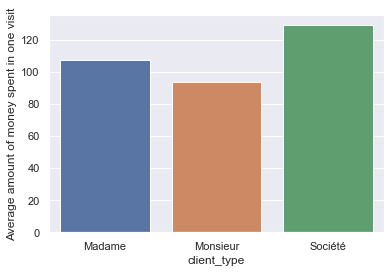

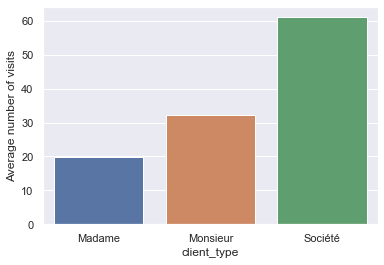

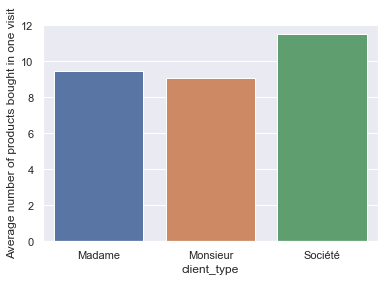

In [959]:
cus_pro_trs_date = customers_products_transactions.groupby(["client_type","client_id","date"]).price_ttc.sum()
cus_pro_trs_date = cus_pro_trs_date.reset_index()
sns.barplot(x = cus_pro_trs_date.groupby("client_type").price_ttc.mean().keys() ,y= cus_pro_trs_date.groupby("client_type").price_ttc.mean())
plt.ylabel("Average amount of money spent in one visit")
plt.show()
sns.barplot(x = cus_pro_trs_date.groupby(["client_type","client_id"]).size().groupby("client_type").mean().keys(),y = cus_pro_trs_date.groupby(["client_type","client_id"]).size().groupby("client_type").mean())
plt.ylabel("Average number of visits")
plt.show()
sns.barplot(x = cus_pro_trs_date.groupby("client_type").size().keys(), y = customers_products_transactions.groupby(["client_type","client_id","date"]).n_products.sum().groupby("client_type").mean())
plt.ylabel("Average number of products bought in one visit")
plt.show()

We notice that there are huge differences among the customer types regarding the average number of visits ans  the average amount of money spent for one visit. There are not huge differences concerning the average number of products bought. 

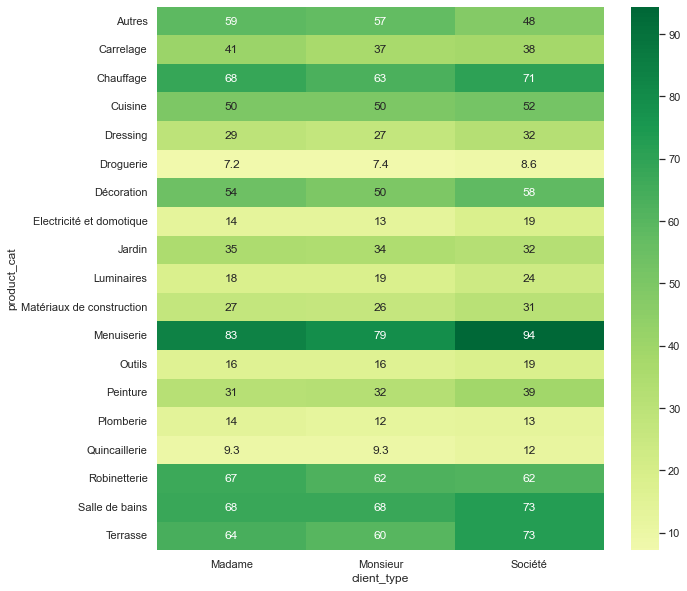

In [960]:
plt.figure(figsize = (10,10))
pivot_table = pd.pivot_table(data=customers_products_transactions, columns='client_type', index='product_cat',values='price_ttc')
sns.heatmap(pivot_table, annot=True, cmap = 'RdYlGn', center=0.117)
plt.show()

This heatmap shows us the average amount of money spent by each type of client regarding a product category. 
Finally, there is indeed a correlation between the three  variables: product_cat, client_type and the amount of money spent. 

### Modeling 

In this part, we will try to create a customer segmentation. In order to do that, we will se the K-mean algorithm, using the elbow method to determine the best number K of groups of customers.

#### Features chosen

The EDA has allowed us to determine relevant features to consider. We will create a new dataset that will contain all thoses characteristics. 
The retained characteristics are the following ones : client_type, average amount of money spent in a store per visit, number of visits, product_categories prefered, zipcode.

#### Preprocessing data

In order to have well-formated datas,we need to delete rows with missing values and we have to transform the categorical variable client_type in an ordinal variable :  

In [961]:
customers.isnull().sum()

index            0
client_date      0
client_type      0
zipcode        197
country          0
dtype: int64

We can drop rows with a missing value since there are only 197 of them.

In [963]:
#customers.drop(columns = "age", inplace = True)
#customers_products_transactions.drop(columns = "age", inplace = True)
customers_products_transactions.dropna(inplace = True)
customers.dropna(inplace = True)

In [964]:
print(customers.isnull().sum())

index          0
client_date    0
client_type    0
zipcode        0
country        0
dtype: int64


In [965]:
ordinal_encoder = OrdinalEncoder()
client_type_ordinal = ordinal_encoder.fit_transform(customers.iloc[:,2].values.reshape(-1,1))
customers.client_type = client_type_ordinal

#### Creation of the dataset

The variables required for the K-mean algorithm are not already computed in the datasets, we have to calculate them : 


In [968]:
customer_segmentation = pd.DataFrame(index = customers.client_id)
#customer_segmentation["client_type"] = customers.client_type.copy()
#Calculating the average amount of money spent in one visit : logarithmic transformation
customer_av_money = customers_products_transactions.groupby(["client_id","date"]).price_ttc.sum().groupby("client_id").mean()

customer_segmentation["customer_av_money"] = np.log1p(customer_av_money)
#Calculating the number of visits
customer_nb_visits = customers_products_transactions.groupby(["client_id","date"]).size().groupby("client_id").size()
customer_segmentation["customer_nb_visits"] = customer_nb_visits
cus_zipcode = customers_products_transactions.groupby("client_id").zipcode.max()
cus_client_type = customers_products_transactions.groupby("client_id").client_type.max()
customer_segmentation["customer_zipcode"] = cus_zipcode
customer_segmentation["client_type"] =cus_client_type
# Calculating the prefered product category for every clients
customers_prefered_cat = customers_products_transactions.groupby(["client_id","product_cat"]).price_ttc.sum().reset_index()
customers_prefered_cat = customers_prefered_cat.sort_values("price_ttc",ascending = False).drop_duplicates(['client_id'])
customer_segmentation["prefered_cat"] = customers_prefered_cat.set_index("client_id").sort_values("client_id").product_cat

customer_segmentation.dropna(inplace = True)
customer_segmentation.isnull().sum()

customer_av_money     0
customer_nb_visits    0
customer_zipcode      0
client_type           0
prefered_cat          0
dtype: int64

We have to re-create ordinal values : 

In [970]:
client_type_ordinal = ordinal_encoder.fit_transform(customer_segmentation.iloc[:,3].values.reshape(-1,1))
customer_segmentation.client_type = client_type_ordinal
prefered_cat_ordinal = ordinal_encoder.fit_transform(customer_segmentation.iloc[:,4].values.reshape(-1,1))
customer_segmentation.prefered_cat = prefered_cat_ordinal
customer_segmentation

,customer_av_money,customer_nb_visits,customer_zipcode,client_type,prefered_cat
client_id,,,,,
0.0,4.284568,77.0,80310.0,1.0,17.0
9.0,4.023790,46.0,59148.0,1.0,13.0
17.0,3.944162,23.0,60200.0,1.0,3.0
20.0,4.420742,204.0,2120.0,1.0,10.0
23.0,4.903316,53.0,59139.0,1.0,0.0
...,...,...,...,...,...
5314171.0,3.934958,1.0,92360.0,1.0,4.0
5314181.0,4.604320,6.0,10400.0,1.0,12.0
5314186.0,4.255116,4.0,74480.0,0.0,12.0


Now that we have preprocessed our data and created our dataset, we can apply the K-mean algorithm.

#### Segmentation with K-means clustering

In [971]:
def make_list_of_K(K, dataframe):
    
    cluster_values = list(range(1, K+1))
    inertia_values=[]
    
    for c in cluster_values:
        model = KMeans(
            n_clusters = c, 
            init='k-means++', 
            max_iter=1000, 
            random_state=42)
        model.fit(dataframe)
        inertia_values.append(model.inertia_)
    
    return inertia_values
results = make_list_of_K(15, customer_segmentation)
print(results)

[96265374217470.7, 25426702990161.61, 11496828545912.674, 5991697875312.016, 3936541280321.425, 2802498461171.5522, 2010472233922.699, 1570434594813.207, 1181683383583.4824, 951436941135.0259, 810703288890.8171, 667836206214.2784, 572857717696.2322, 475951676475.48676, 395570514543.5175]


The table results gives the inertia (usual **metrics** for k-mean algorithm) for several k-values, . the inertia is defined by the mathematic formula of the "within-cluster sum-of-squared-distances ". 

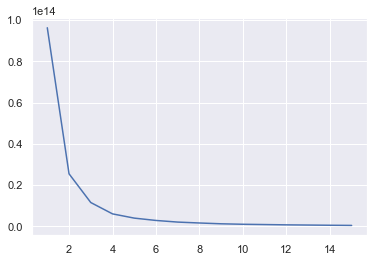

In [972]:
plt.plot(range(1,16),results)

The model seems to converge but we can see that it gives values which are very high. I think that it is because of the use of the zipcode column. 
Indeed, when we delete this column from the dataframe we obtain a new prediction which has a lower inertia value : 

[181877252.68420762, 77073592.57326455, 42756426.432135716, 27561094.33987986, 19652536.894622248, 15065302.03542476, 12213611.536366312, 10168258.284634596, 8813175.829023538, 7772921.45019996, 6815915.119209801, 6165237.55708691, 5625452.558785937, 5135350.017277067, 4679166.447279368]


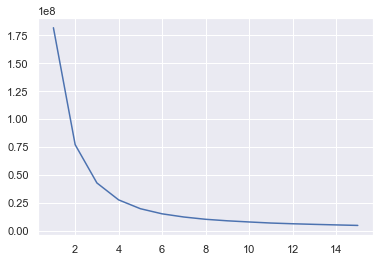

In [973]:
customer_segmentation.drop(axis = 1, columns = "customer_zipcode", inplace = True)
results = make_list_of_K(15, customer_segmentation)
print(results)
plt.plot(range(1,16),results)

We have now values that are more acceptable. With the elbow method, we can see that for k = 5 the inertia of the model is low and we do not have too many groups. 
We do have our segmentation with k = 5.


In [974]:
best_kmeans_model = KMeans(n_clusters = 4, 
                              init='k-means++', 
                              max_iter=500, 
                              random_state=42)

customer_segmentation["cluster"] = best_kmeans_model.fit_predict(customer_segmentation)
customer_segmentation

,customer_av_money,customer_nb_visits,client_type,prefered_cat,cluster
client_id,,,,,
0.0,4.284568,77.0,1.0,17.0,3
9.0,4.023790,46.0,1.0,13.0,0
17.0,3.944162,23.0,1.0,3.0,2
20.0,4.420742,204.0,1.0,10.0,1
23.0,4.903316,53.0,1.0,0.0,0
...,...,...,...,...,...
5314171.0,3.934958,1.0,1.0,4.0,2
5314181.0,4.604320,6.0,1.0,12.0,2
5314186.0,4.255116,4.0,0.0,12.0,2


Our inertia is still very very high, we cannot say that he have a super efficient model. 

## Results interpretation

It is now time to interpret our results. 
First of all, let's try to see in which cluster a customer belongs.

[]

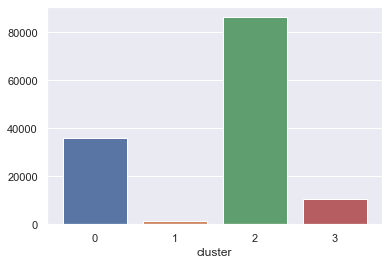

In [975]:
sns.barplot(x = customer_segmentation.groupby("cluster").size().keys() , y = customer_segmentation.groupby("cluster").size() )
plt.plot()

Groups are not equivalent, the group 2 is way bigger than the others and nobody belongs to the third group. 
Let's try to understand why the algorithm has made those choice. 


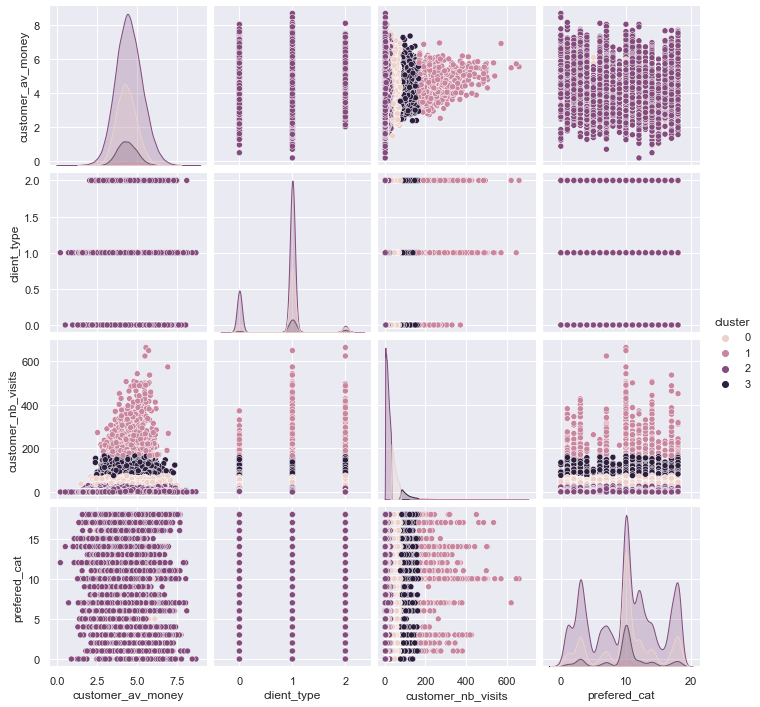

In [976]:
sns.pairplot(data = customer_segmentation, vars=['customer_av_money','client_type','customer_nb_visits','prefered_cat'], hue = "cluster")

Thanks to the pairplot, we can evaluate that the predominant variable is customer_nb_visits : it is normal because it is the variable that has the biggest standard variation. The model has well separated the customers regarding their number of visits in a store, but it has failed to provide groups which take into account the 4 variables.

## Further improvements 

Since the timing was limited i didn't had the time to explore several possibilities and analysis.  
I think that the first problem is the huge numerical differences between the variables, i should have put my own values for the ordinal values of client_type, because it has almost no impact on the simulation.  
I should reconsider other variables that have been put aside and that may be relevant to use, such as the date of the last visit in a store.   
Finally, i hadn't the time to solve the problem of local communication, which will be a priority if i had to continue this project 